# Supernovae Image Generation with Generative Adversarial Network.

Author: Claudio Canales Donoso.
e-mail: claudio.canales@amtc.uchile.cl


The generation of Astronomical images (supernovae) is implemented by:

1. DCGAN
2. WGAN-GP
3. Conditional Image Generation.

## Libraries

In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import torch 
import torchvision.transforms as transforms
from torchsummary import summary
import os 

# Dataset loader
from src.utils.stamp_loader import get_SN_dataset, get_full_dataset, get_training_loaders

# Generative models
from src.dcgan import DCGAN
from src.wgangp import WGAN_GP
from src.AstroGAN import AstroGAN

# Configuration
from src.config import parse_args

# Generation and visualization
from torchvision import utils
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

2023-12-19 21:25:36.648903: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 21:25:36.919752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 21:25:36.919866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 21:25:36.958957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 21:25:37.039920: I tensorflow/core/platform/cpu_feature_guar

## Dataloader of Supernovae

Image size: 32x32x3

In [3]:
# Torch transformation for image preprocessing
resolution = 32
trans = transforms.Compose([
    transforms.Resize(resolution),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

resizer = transforms.Resize((28, 28))

dataset_directory = os.getcwd() + "/datasets/stamp/"
train_dataset, test_dataset = get_SN_dataset(dataset_directory,file_name="stamp_dataset_only_images_63.pkl", transform=trans)

## Generation of images and visualization functions.

In [4]:
# Generation of images and visualization tools
def unnormalize_images(images):
    images = images.mul(0.5).add(0.5)
    return images

def generate_images(model, n_imgs=64):
    z = torch.randn(n_imgs, 100, 1, 1)
    samples = model.G(z).cpu()
    samples = unnormalize_images(samples)
    samples = samples.data.cpu()
    return samples


def show(imgs, save_img=True, filename="output.pdf"):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), interpolation="none")
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if save_img:
        fig.tight_layout()
        plt.tight_layout()
        fig.savefig("./imgs/"+filename, dpi=200)


def generate_images_astrogan(model, n_imgs=64, device="cuda"):
    z = torch.randn(n_imgs, 150, 1, 1).to(device)
    samples = model.G_sci.generate_sci_ref(z)
    samples = unnormalize_images(samples)
    return samples

## DCGAN Model Loading.

In [4]:
# Loading DCGAN-MODEL
args = parse_args()
dcgan = DCGAN(args)
dcgan.load_model("./models/dcgan/discriminator.pkl", "./models/dcgan/generator.pkl")
dcgan.G = dcgan.G.to("cuda")

DCGAN model initalization.
Cuda enabled flag: 
True
Generator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/dcgan/generator.pkl.
Discriminator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/dcgan/discriminator.pkl-


## Model Summary

### Generator

In [5]:
summary(dcgan.G, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]          12,291
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 12,141,827
Trainable params: 12,141,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

### Discriminator.

In [6]:
summary(dcgan.D, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]          12,544
       BatchNorm2d-2          [-1, 256, 16, 16]             512
         LeakyReLU-3          [-1, 256, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]       8,389,632
       BatchNorm2d-8           [-1, 1024, 4, 4]           2,048
         LeakyReLU-9           [-1, 1024, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]          16,385
          Sigmoid-11              [-1, 1, 1, 1]               0
          Flatten-12                       [-1]               0
Total params: 10,519,809
Trainable params: 10,519,809
Non-trainable params: 0
-------------------------

### DCGAN - Image Generation.
1. 3 Channels mixed.
2. Channels separated [Difference, Science, Reference]

In [ ]:
dcgan.G = dcgan.G.to("cuda")
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(dcgan, 64).cpu()
sz = fake_images.shape
fake_images_sep = [fake_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
real_images_sep = [real_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
fake_images_grids = [utils.make_grid(s) for s in fake_images_sep]
real_images_grids = [utils.make_grid(s) for s in real_images_sep]

print("Real Images - Channels separated")
show(real_images_grids, filename="real_1_channel_dcgan.pdf")
print("Fake Images - Channels separated")
show(fake_images_grids, filename="fake_1_channel_dcgan.pdf")

Real vs Generated RGB Images


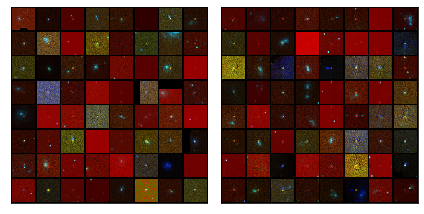

In [8]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(dcgan, 64)
real_images_grid = utils.make_grid(real_images)
fake_images_grid = utils.make_grid(fake_images)

print("Real vs Generated RGB Images")
show([real_images_grid, fake_images_grid], filename="real_fake_dcgan_rgb.pdf")

## Training Curves

In [4]:
def get_values(directory_files, expr_id):
    step, value = [], []
    m = np.loadtxt(directory_files + "/" + expr_id, skiprows=1, delimiter=",")
    step.append(m[:, 1])
    value.append(m[:, 2])
    step = np.array(step).ravel()
    value = np.array(value).ravel()
    return step, value

def fd(expr_ids, filter):
    f = []
    for i in expr_ids:
        if filter in i:
            f.append(i)
    return f

['run-.-tag-g_loss_dcgan.csv', 'run-.-tag-d_loss_dcgan.csv']


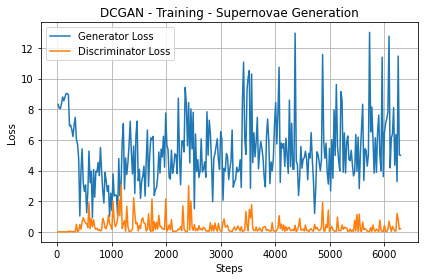

In [39]:
directory_files = "./logs/dcgan" 
expr_ids = [f for f in os.listdir(directory_files)]
ids = fd(expr_ids, "loss")
results = []
print(ids)
for i in ids:
    results.append(get_values(directory_files, i))

plt.figure(figsize=(6,4))

for i, label in zip([0,1], ["Generator Loss","Discriminator Loss"]):
    plt.plot(results[i][0],results[i][1], label=label,color="C"+str(i))

plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("DCGAN - Training - Supernovae Generation")
plt.grid()
plt.tight_layout()
plt.savefig("imgs/training_DCGAN"+".pdf", dpi=600)

### Dataset of supernovae Image Generation.

In [41]:
#create dataset dictionary
dataset = {'images':[],'labels':[]}
size=50000
model_path = "dcgan"

for i in tqdm(range(int(size))):
    fake_sample = resizer(generate_images(dcgan, 1))
    dataset['images'].append(fake_sample.cpu().detach().numpy()[0])
    dataset['labels'].append(1.0)

#save the dataset as a pickle file
with open(f'./generated_dataset/generated_dataset_{size}_model{model_path}.pkl', 'wb') as f:
    pickle.dump(dataset, f) 

  0%|          | 0/50000 [00:00<?, ?it/s]/home/ccdonosoo/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 50000/50000 [05:26<00:00, 153.27it/s]


## FID SCORE

In [17]:
import PIL.Image as Image
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(model, batch, batch_size=1000, latent_dim=100):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device="cuda")
        model.eval()
        fake_batch = model(noise)
        fake = (interpolate(fake_batch)+1)/2*255
        real = (interpolate(batch[0])+1)/2*255
        return fake.type(torch.uint8), real.type(torch.uint8)

batch = train_dataset[np.random.choice(len(train_dataset), 1000)]
a = evaluation_step(dcgan.G, batch)

fid = FrechetInceptionDistance()

fid.update(a[0], real=True)
fid.update(a[1], real=False)
fid.compute()

tensor(35.3539)

## WGAN-GP Model Loading.

In [18]:
# Loading DCGAN-MODEL
args = parse_args()
wgan = WGAN_GP(args)
wgan.load_model("./models/wgangp/discriminator_wgan.pkl", "./models/wgangp/generator_wgan.pkl")

WGAN_GradientPenalty init model.
Cuda enabled flag: 
True
Generator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/wgangp/generator_wgan.pkl.
Discriminator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/wgangp/discriminator_wgan.pkl-


## Model Summary

### Generator

In [19]:
summary(wgan.G, input_size=(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]          12,291
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 12,141,827
Trainable params: 12,141,827
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

### Discriminator

In [20]:
summary(wgan.D, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]          12,544
    InstanceNorm2d-2          [-1, 256, 16, 16]               0
         LeakyReLU-3          [-1, 256, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]       2,097,664
    InstanceNorm2d-5            [-1, 512, 8, 8]               0
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]       8,389,632
    InstanceNorm2d-8           [-1, 1024, 4, 4]               0
         LeakyReLU-9           [-1, 1024, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]          16,385
          Flatten-11                       [-1]               0
Total params: 10,516,225
Trainable params: 10,516,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

### WGAN-GP - Image Generation.
1. 3 Channels mixed.
2. Channels separated [Difference, Science, Reference]

Real vs Generated RGB Images


/home/ccdonosoo/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


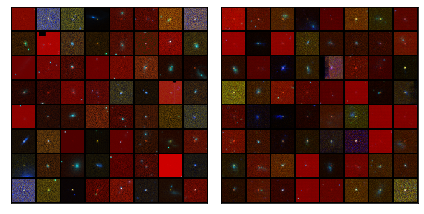

In [21]:
wgan.G = wgan.G.to("cpu")
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(wgan, 64)
real_images_grid = utils.make_grid(real_images)
fake_images_grid = utils.make_grid(fake_images)

print("Real vs Generated RGB Images")
show([real_images_grid, fake_images_grid], filename="real_fake_wgangp_rgb.pdf")

Real Images - Channels separated
Fake Images - Channels separated


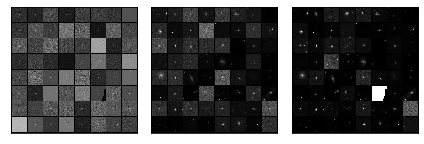

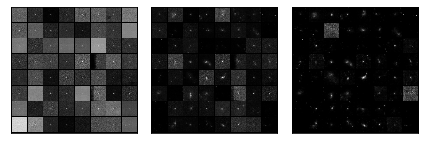

In [22]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)
fake_images = generate_images(wgan, 64).cpu()
sz = fake_images.shape
fake_images_sep = [fake_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
real_images_sep = [real_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
fake_images_grids = [utils.make_grid(s) for s in fake_images_sep]
real_images_grids = [utils.make_grid(s) for s in real_images_sep]

print("Real Images - Channels separated")
show(real_images_grids, filename="real_1_channel_wgangp.pdf")
print("Fake Images - Channels separated")
show(fake_images_grids, filename="fake_1_channel_wgangp.pdf")

## Training Curves.

['run-.-tag-loss_g_wgan.csv', 'run-.-tag-wgan_loss_distance.csv', 'run-.-tag-loss_d_wgan.csv']


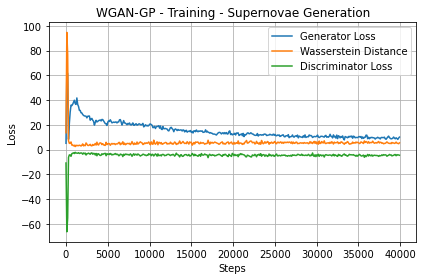

In [38]:
directory_files = "./logs/wgan" 
expr_ids = [f for f in os.listdir(directory_files)]
ids = fd(expr_ids, "loss")
results = []
print(ids)
for i in ids:
    results.append(get_values(directory_files, i))

plt.figure(figsize=(6,4))

for i, label in zip([0,1,2], ["Generator Loss", "Wasserstein Distance", "Discriminator Loss"]):
    plt.plot(results[i][0],results[i][1], label=label,color="C"+str(i))

plt.legend()
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("WGAN-GP - Training - Supernovae Generation")
plt.grid()
plt.tight_layout()
plt.savefig("imgs/training_WGANGP"+".pdf", dpi=600)

### Dataset of supernovae Image Generation - WGAN-GP.

In [47]:
dataset = {'images':[],'labels':[]}
size=50000
model_path = "wgangp"

for i in tqdm(range(int(size))):
    fake_sample = resizer(generate_images(wgan, 1))
    dataset['images'].append(fake_sample.cpu().detach().numpy()[0])
    dataset['labels'].append(1.0)

#save the dataset as a pickle file
with open(f'./generated_dataset/generated_dataset_{size}_model{model_path}.pkl', 'wb') as f:
    pickle.dump(dataset, f) 

100%|██████████| 50000/50000 [05:20<00:00, 156.01it/s]


In [24]:
import PIL.Image as Image
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(model, batch, batch_size=1000, latent_dim=100):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device="cuda")
        model.eval()
        fake_batch = model(noise)
        fake = (interpolate(fake_batch)+1)/2*255
        real = (interpolate(batch[0])+1)/2*255
        return fake.type(torch.uint8), real.type(torch.uint8)

batch = train_dataset[np.random.choice(len(train_dataset), 1000)]
wgan.G = wgan.G.to("cuda")
a = evaluation_step(wgan.G, batch)

fid = FrechetInceptionDistance()

fid.update(a[0], real=True)
fid.update(a[1], real=False)
fid.compute()

/home/ccdonosoo/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(37.7345)

## DCGAN - Conditional Generation.

In [25]:
model = AstroGAN()
model.load_full_model(
    D_model_filename_ref="./models/astrogan/discriminator_ref.pkl", 
    G_model_filename_ref="./models/astrogan/generator_ref.pkl",
    D_model_filename_sci="./models/astrogan/discriminator_sci.pkl",
    G_model_filename_sci="./models/astrogan/generator_sci.pkl")

AstroGAN model initalization.
Generator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/astrogan/generator_ref.pkl.
Discriminator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/astrogan/discriminator_ref.pkl-
Generator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/astrogan/generator_sci.pkl.
Discriminator model loaded from /home/ccdonosoo/Desktop/WGAN_ASTRO/./models/astrogan/discriminator_sci.pkl-
AstroGAN Loaded Succesfully


## Model Summary

### Generation Reference.

In [26]:
summary(model.G_ref, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 32, 32]           4,097
             Tanh-11            [-1, 1, 32, 32]               0
Total params: 12,133,633
Trainable params: 12,133,633
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

### Generator Science-Difference

In [27]:
summary(model.G_sci, input_size=(150,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]           5,050
   ConvTranspose2d-2           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-3           [-1, 1024, 4, 4]           2,048
              ReLU-4           [-1, 1024, 4, 4]               0
   ConvTranspose2d-5            [-1, 512, 8, 8]       8,389,120
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
              ReLU-7            [-1, 512, 8, 8]               0
   ConvTranspose2d-8          [-1, 256, 16, 16]       2,097,408
       BatchNorm2d-9          [-1, 256, 16, 16]             512
             ReLU-10          [-1, 256, 16, 16]               0
  ConvTranspose2d-11            [-1, 2, 32, 32]           8,194
  ConvTranspose2d-12           [-1, 1024, 4, 4]       1,639,424
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
             ReLU-14           [-1, 102

### Discriminator Refenrence

In [51]:
summary(model.D_ref, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]           4,352
       BatchNorm2d-2          [-1, 256, 16, 16]             512
         LeakyReLU-3          [-1, 256, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]       8,389,632
       BatchNorm2d-8           [-1, 1024, 4, 4]           2,048
         LeakyReLU-9           [-1, 1024, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]          16,385
          Sigmoid-11              [-1, 1, 1, 1]               0
          Flatten-12                       [-1]               0
Total params: 10,511,617
Trainable params: 10,511,617
Non-trainable params: 0
-------------------------

### Discriminator Science

In [52]:
summary(model.D_sci, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]           8,448
       BatchNorm2d-2          [-1, 256, 16, 16]             512
         LeakyReLU-3          [-1, 256, 16, 16]               0
            Conv2d-4            [-1, 512, 8, 8]       2,097,664
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
            Conv2d-7           [-1, 1024, 4, 4]       8,389,632
       BatchNorm2d-8           [-1, 1024, 4, 4]           2,048
         LeakyReLU-9           [-1, 1024, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]          16,385
          Sigmoid-11              [-1, 1, 1, 1]               0
          Flatten-12                       [-1]               0
Total params: 10,515,713
Trainable params: 10,515,713
Non-trainable params: 0
-------------------------

### Generation of Conditional GAN.

In [53]:
def generate_images_astrogan(model, n_imgs=64, device="cuda"):
    z = torch.randn(n_imgs, 150, 1, 1).to(device)
    samples = model.G_sci.generate_sci_ref(z)
    samples = unnormalize_images(samples)
    return samples

### Conditional DCGAN - Image Generation.
1. 3 Channels mixed.
2. Channels separated [Difference, Science, Reference]

torch.Size([64, 3, 32, 32]) torch.Size([64, 3, 32, 32])
torch.Size([3, 274, 274])
Real vs Generated RGB Images


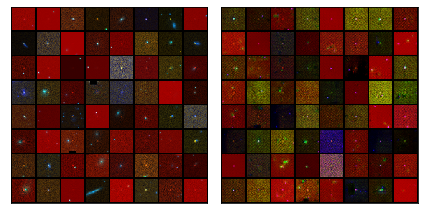

In [54]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)[:,:,:,:]
fake_images = generate_images_astrogan(model, n_imgs=64)
print(real_images.shape, fake_images.shape)
real_images_grid = utils.make_grid(real_images)
fake_images_grid = utils.make_grid(fake_images)

print(real_images_grid.shape)

print("Real vs Generated RGB Images")
show([real_images_grid, fake_images_grid], filename="real_fake_astrogan_rgb.pdf")

Real Images - Channels separated
Fake Images - Channels separated


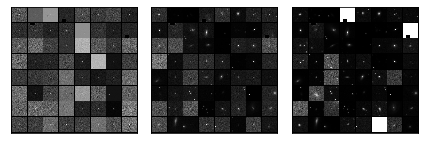

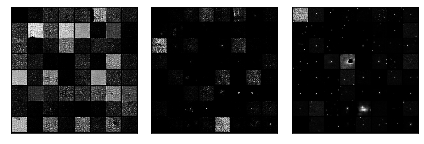

In [55]:
real_images, _ = train_dataset[np.random.choice(len(train_dataset), 64)]
real_images = unnormalize_images(real_images)[:,:,:,:]
fake_images = generate_images_astrogan(model, n_imgs=64)
sz = fake_images.shape
fake_images_sep = [fake_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
real_images_sep = [real_images[:, i, :, :] .view(sz[0],1,sz[2],sz[3]) for i in range(3)]
fake_images_grids = [utils.make_grid(s) for s in fake_images_sep]
real_images_grids = [utils.make_grid(s) for s in real_images_sep]

print("Real Images - Channels separated")
show(real_images_grids, filename="real_1_channel_astrogan.pdf")
print("Fake Images - Channels separated")
show(fake_images_grids, filename="fake_1_channel_astrogan.pdf")

## Training Curves

<Figure size 432x288 with 0 Axes>

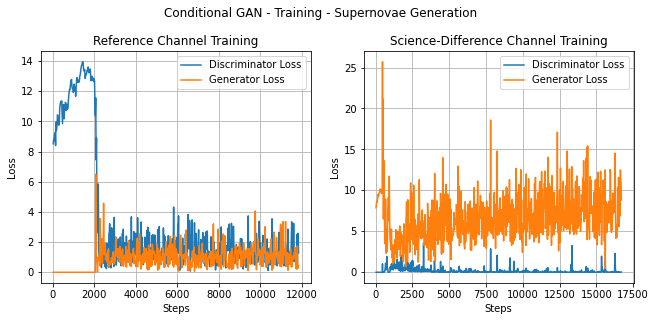

In [37]:
plt.figure(figsize=(6,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 4.5))

directory_files = "./logs/conditionalgan" 

# Reference
expr_ids = [f for f in os.listdir(directory_files)]
ids = fd(expr_ids, "ref")
results = []

for i in ids:
    results.append(get_values(directory_files, i))

for i, label in zip([0,1], ["Discriminator Loss", "Generator Loss"]):
    ax1.plot(results[i][0],results[i][1], label=label,color="C"+str(i))

ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid()
ax1.set_title("Reference Channel Training")

# sci
expr_ids = [f for f in os.listdir(directory_files)]
ids = fd(expr_ids, "sci")
results = []

for i in ids:
    results.append(get_values(directory_files, i))

for i, label in zip([0,1], ["Discriminator Loss", "Generator Loss"]):
    ax2.plot(results[i][0],results[i][1], label=label,color="C"+str(i))

fig.suptitle("Conditional GAN - Training - Supernovae Generation")

ax2.set_xlabel("Steps")
ax2.set_ylabel("Loss")
ax2.set_title("Science-Difference Channel Training")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.savefig("imgs/training_Conditional_GAN"+".pdf", dpi=600)

In [56]:
#create dataset dictionary
dataset = {'images':[],'labels':[]}
size=50000
model_path = "conditional_gan"

for i in tqdm(range(int(size))):
    fake_sample = resizer(generate_images_astrogan(model, n_imgs=1))
    dataset['images'].append(fake_sample.cpu().detach().numpy()[0])
    dataset['labels'].append(1.0)

#save the dataset as a pickle file
with open(f'./generated_dataset/generated_dataset_{size}_model{model_path}.pkl', 'wb') as f:
    pickle.dump(dataset, f) 

100%|██████████| 50000/50000 [00:45<00:00, 1097.23it/s]


In [30]:
import PIL.Image as Image
import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(model, batch, batch_size=1000, latent_dim=150):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device="cuda")
        fake_batch = model.G_sci.generate_sci_ref(noise)
        fake = (interpolate(fake_batch)+1)/2*255
        real = (interpolate(batch[0])+1)/2*255
        return fake.type(torch.uint8), real.type(torch.uint8)

batch = train_dataset[np.random.choice(len(train_dataset), 1000)]
a = evaluation_step(model, batch)

fid = FrechetInceptionDistance()

fid.update(a[0], real=True)
fid.update(a[1], real=False)
fid.compute()